In [1]:
import pandas as pd
import numpy as np
import hdbscan
import umap

In [2]:
!pip install hdbscan
!pip install umap-learn

In [3]:
test_df = pd.read_csv("data/test_nasi_metadata.csv")
train_df = pd.read_csv("data/train_nasi_metadata.csv")

In [4]:
test_latents = np.load("data/test_nasi_latents.npy")
train_latents = np.load("data/train_nasi_latents.npy")

In [5]:
print(f"Test latents shape: {test_latents.shape}, train latents shape: {train_latents.shape}")

Test latents shape: (4319, 16), train latents shape: (16146, 16)


In [6]:
print(f"Test dataframe shape: {test_df.shape}, train dataframe shape: {train_df.shape}")
assert test_df.shape[0] == test_latents.shape[0]
assert train_df.shape[0] == train_latents.shape[0]

Test dataframe shape: (4319, 5), train dataframe shape: (16146, 5)


In [7]:
test_df.iloc[[5]]

,Unnamed: 0,individual_id,expression_id,individual_name,expression_name
5,5,0,0,FaceTalk_170908_03277_TA,lips_up


In [8]:
train_df.iloc[[5]]
all_df = pd.concat([train_df, test_df])

In [9]:
all_df.shape

(20465, 5)

In [10]:
all_latents = np.vstack((train_latents, test_latents))

In [11]:
assert (all_latents[1] == train_latents[1]).all()

I do clustering here, instead of loading preprocessed data

Silhouette method for number of clusters

In [12]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm import tqdm

In [ ]:

sil = []
kmax = 150

Sum_of_squared_distances = [] #for elbow method
ks = range(2, kmax+1)
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(ks):
  kmeans = KMeans(n_clusters = k).fit(all_latents)
  labels = kmeans.labels_
  sil.append(silhouette_score(all_latents, labels, metric = 'euclidean'))
  Sum_of_squared_distances.append(kmeans.inertia_) #for elbow method

In [ ]:
max(labels)
plt.plot(range(2, kmax+1),sil, scalex=True, scaley=True, data=None)
plt.title("Silouhette score")


In [130]:
  cluster = KMeans(n_clusters = 12).fit(all_latents)
  #labels = kmeans.labels_

Elbow method for number of clusters

In [ ]:
len(Sum_of_squared_distances)

In [ ]:
len(ks)

In [ ]:

plt.plot(ks, Sum_of_squared_distances)
#plt.plot(range(2, kmax+1),Sum_of_squared_distances, scalex=True, scaley=True, data=None)

plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")
plt.show()

In [111]:
cluster = hdbscan.HDBSCAN(min_cluster_size=200,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(all_latents)
#for now it was trial and error, however the correct "minclustersize" can be calculated using some trials

In [112]:
max(cluster.labels_)

11

Text(0.5, 1.0, 'Visualization of one instance of clustering through HDBSCAN')

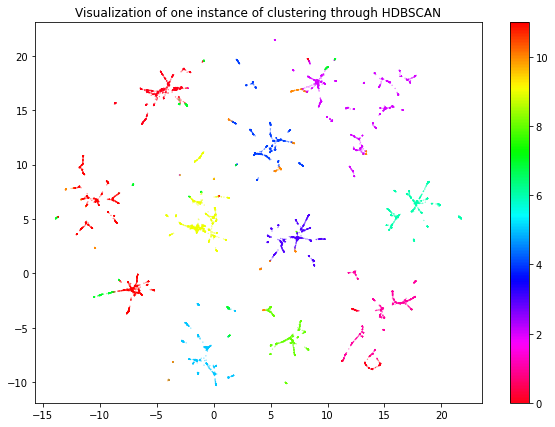

In [131]:
import matplotlib.pyplot as plt
import umap.umap_ as umap
umap_data = umap.UMAP(n_neighbors=100, n_components=2, min_dist=0.0, metric='cosine').fit_transform(all_latents)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 7))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.title("Visualization of one instance of clustering through HDBSCAN")

Now I try clustering with dimensionality reduction

In [114]:
'''umap_embeddings = umap.UMAP(n_neighbors=100, 
                            n_components=5, 
                            metric='cosine').fit_transform(all_latents)

cluster = hdbscan.HDBSCAN(min_cluster_size=60,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)'''

"umap_embeddings = umap.UMAP(n_neighbors=100, \n                            n_components=5, \n                            metric='cosine').fit_transform(all_latents)\n\ncluster = hdbscan.HDBSCAN(min_cluster_size=60,\n                          metric='euclidean',                      \n                          cluster_selection_method='eom').fit(umap_embeddings)"

In [132]:
max(cluster.labels_)

11

**What is the algorithm clustering?**

**Q: if k = 12, or minimum cluster size is s.t. clusters = 12 in hdbscan, will the clusters correspond to the different individuals?**

In [116]:
#all_df.insert(1, "clust_labels", cluster.labels_)

In [117]:
all_df.tail(100)

,Unnamed: 0,individual_id,expression_id,individual_name,expression_name
4219,4219,2,11,FaceTalk_170725_00137_TA,mouth_middle
4220,4220,2,11,FaceTalk_170725_00137_TA,mouth_middle
4221,4221,2,11,FaceTalk_170725_00137_TA,mouth_middle
4222,4222,2,11,FaceTalk_170725_00137_TA,mouth_middle
4223,4223,2,11,FaceTalk_170725_00137_TA,mouth_middle
...,...,...,...,...,...
4314,4314,2,11,FaceTalk_170725_00137_TA,mouth_middle
4315,4315,2,11,FaceTalk_170725_00137_TA,mouth_middle
4316,4316,2,11,FaceTalk_170725_00137_TA,mouth_middle
4317,4317,2,11,FaceTalk_170725_00137_TA,mouth_middle


In [133]:
clusters_lists = [set() for i in range(max(cluster.labels_)+1)]
individuals_lists = [set() for i in range(all_df["individual_id"].max()+1)]
#I want to make sets of clusters labels, individuals ids and more if necessary (e.g. expressions?)
individuals_ids = all_df["individual_id"].tolist()
for i in range(len(cluster.labels_)):
    if cluster.labels_[i] != -1:
        clusters_lists[cluster.labels_[i]].add(i)
    individuals_lists[individuals_ids[i]].add(i)

In [134]:
max(cluster.labels_)

11

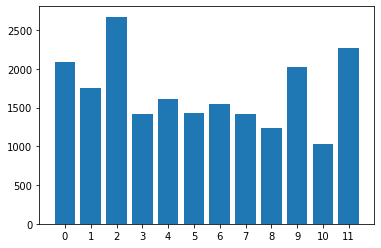

In [135]:
arr = np.array(cluster.labels_)

labels, counts = np.unique(arr, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

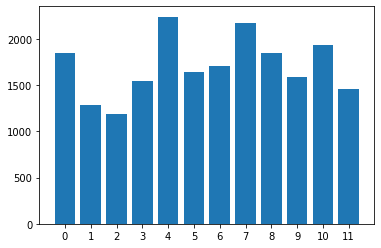

In [136]:
arr = np.array(individuals_ids)

labels, counts = np.unique(arr, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

In [137]:
IoUs = np.zeros((len(clusters_lists), len(individuals_lists)))

In [138]:
IoUs.shape

(12, 12)

In [139]:
for i in range(len(clusters_lists)):
    for j in range(len(individuals_lists)): 
        intersection = len(individuals_lists[j].intersection(clusters_lists[i]))
        union = len(individuals_lists[j].union(clusters_lists[i]))
        IoUs[i][j] = intersection/union
        #print(f"IoU {i,j} is {intersection/union}")


In [140]:
test_df.iloc[2000]

Unnamed: 0                             2000
individual_id                             1
expression_id                             2
individual_name    FaceTalk_170811_03275_TA
expression_name                   bareteeth
Name: 2000, dtype: object

Text(33.0, 0.5, 'Cluster')

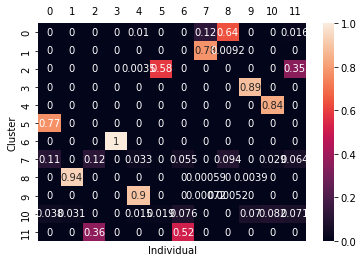

In [141]:
import seaborn as sns
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax = sns.heatmap(IoUs, annot=True)
ax.set_xlabel("Individual")
ax.set_ylabel("Cluster")

Another trial could be doing the percentage of "correct guesses" 
i.e. for each element of a cluster, check if the element is in the individuals set, if so, increment and calculate percentage

In [142]:
percentages = np.zeros((len(clusters_lists), len(individuals_lists)))
for i in range(len(clusters_lists)):
    for j in range(len(individuals_lists)): 
        for cluster_item in clusters_lists[i]:
            if cluster_item in individuals_lists[j]:
                percentages[i][j] += 1
        percentages[i][j] /= len(clusters_lists[i])
        


Text(33.0, 0.5, 'Cluster')

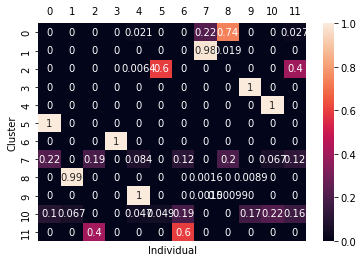

In [143]:
import seaborn as sns
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax = sns.heatmap(percentages, annot=True)
ax.set_xlabel("Individual")
ax.set_ylabel("Cluster")